In [ ]:
%reset -f
import plotly.express as px
from graphviz import Digraph
from collections import defaultdict
from itertools import product
import numpy as np



In [ ]:
LAM = 1
b = 2
P = [0.6, 0.25, 0.15]
NUM_SERVERS = 3
MAX_QUEUE_SIZE = 3
TOTAL_CLIENTS = 6
N = len(P)

# Print
MU = 1/b
assert sum(P) == 1
print(f"λ = {LAM}\n{b = }\nμ = {MU}")
for i in range(len(P)):
    print(f'p{i+1} = {P[i]}')

λ = 1
b = 2
μ = 0.5
p1 = 0.6
p2 = 0.25
p3 = 0.15


In [ ]:
server_states = [0, 1]

server_combinations = list(product(server_states, repeat=NUM_SERVERS))
queue_states = range(MAX_QUEUE_SIZE + 1)

combined_states = list(product(server_combinations, queue_states))

transitions = {}

In [ ]:

for in_state in combined_states:
    server_state, queue_size = in_state

    transitions[in_state] = {}

    if sum(server_state) + queue_size < TOTAL_CLIENTS:
        if sum(server_state) == NUM_SERVERS and queue_size < MAX_QUEUE_SIZE:
            out_queue_size = queue_size + 1
            new_state = (tuple(server_state), out_queue_size)
            transitions[in_state][new_state] = LAM
        if queue_size == 0:
          for idx in range(NUM_SERVERS):
              if server_state[idx] == 0:
                  out_state = list(server_state)
                  out_state[idx] = 1

                  new_state = (tuple(out_state), queue_size)
                  transitions[in_state][new_state] = LAM * P[idx]

    if queue_size > 0 and sum(server_state) == NUM_SERVERS:
        new_state = (server_state, queue_size - 1)
        transitions[in_state][new_state] = MU
    elif queue_size == 0:
        for idx in range(NUM_SERVERS):
          if server_state[idx] == 1:
              out_state = list(server_state)
              out_state[idx] = 0
              new_state = (tuple(out_state), queue_size)
              transitions[in_state][new_state] = MU




In [ ]:
transitions = {state: out_states for state, out_states in transitions.items() if out_states}

In [ ]:
# Output the states and their transitions
for state, transition in transitions.items():
    print(f"State: {state}")
    for next_state, prob in transition.items():
        print(f"  -> Next State: {next_state} with Probability: {prob:.4f}")

State: ((0, 0, 0), 0)
  -> Next State: ((1, 0, 0), 0) with Probability: 0.6000
  -> Next State: ((0, 1, 0), 0) with Probability: 0.2500
  -> Next State: ((0, 0, 1), 0) with Probability: 0.1500
State: ((0, 0, 1), 0)
  -> Next State: ((1, 0, 1), 0) with Probability: 0.6000
  -> Next State: ((0, 1, 1), 0) with Probability: 0.2500
  -> Next State: ((0, 0, 0), 0) with Probability: 0.5000
State: ((0, 1, 0), 0)
  -> Next State: ((1, 1, 0), 0) with Probability: 0.6000
  -> Next State: ((0, 1, 1), 0) with Probability: 0.1500
  -> Next State: ((0, 0, 0), 0) with Probability: 0.5000
State: ((0, 1, 1), 0)
  -> Next State: ((1, 1, 1), 0) with Probability: 0.6000
  -> Next State: ((0, 0, 1), 0) with Probability: 0.5000
  -> Next State: ((0, 1, 0), 0) with Probability: 0.5000
State: ((1, 0, 0), 0)
  -> Next State: ((1, 1, 0), 0) with Probability: 0.2500
  -> Next State: ((1, 0, 1), 0) with Probability: 0.1500
  -> Next State: ((0, 0, 0), 0) with Probability: 0.5000
State: ((1, 0, 1), 0)
  -> Next Sta

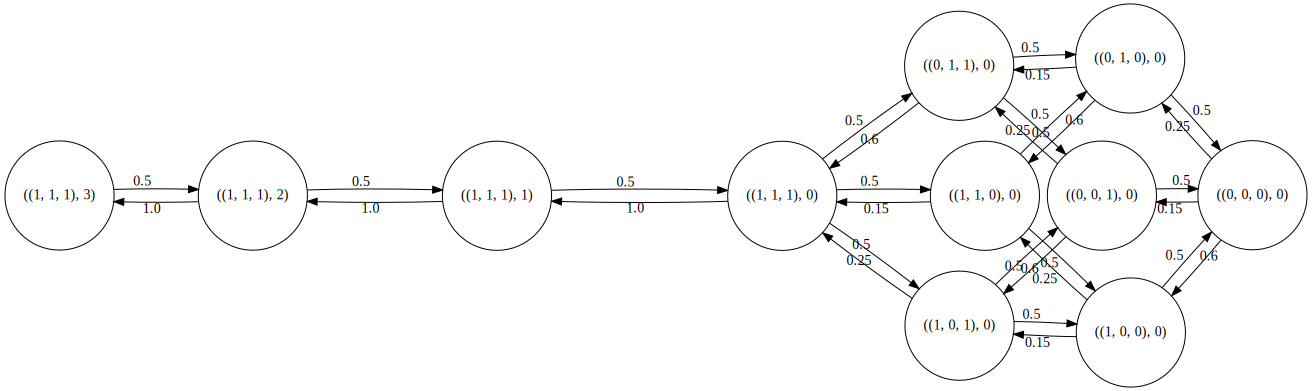

In [ ]:
def make_state_graph(states):
    g = Digraph(engine='sfdp')
    g.attr(overlap='scalexy')

    for in_state, out_states in states.items():
        for out_state, prob in out_states.items():
            in_id = str(in_state)
            out_id = str(out_state)

            if prob - 0.001 > 0:
              id = str(in_state)
              g.node(id, id, shape='circle')
              g.edge(in_id, out_id, f'{1.*prob:.3}')
    return g

display(make_state_graph(transitions))

In [ ]:
def make_state_indices(states):
    idx = {}
    for i, state in enumerate(states):
        idx[state] = i
        idx[i] = state
    return idx

def make_transition_rate_matrix(states, state_idx):
    N = len(states)
    m = np.zeros((N, N))
    for in_state, out_states in states.items():
        in_idx = state_idx[in_state]
        for out_state, rate in out_states.items():
            out_idx = state_idx[out_state]
            m[in_idx, out_idx] = rate
    for i in range(N):
        m[i, i] = -sum(m[i, :])
    return m

state_idx = make_state_indices(transitions)
transition_rate_matrix = make_transition_rate_matrix(transitions, state_idx)

fig = px.imshow(
    transition_rate_matrix,
    text_auto = True,
    height = 800,
    color_continuous_scale = [[0, 'red'], [0.5, '#f8f8f8'], [1, 'green']],
    color_continuous_midpoint = 0.0,
)
fig.update_layout(
    title='Filtered Transition Rate Matrix',
    xaxis_title='Next State',
    yaxis_title='Current State',
)
fig.show()

In [ ]:
def solve_states(transition_rate_matrix):
    shape = transition_rate_matrix.shape
    assert len(shape) == 2
    assert shape[0] == shape[1]
    N = shape[0]

    equations = transition_rate_matrix.copy().transpose()
    equations[0, :] = np.ones(N)
    bvector = np.zeros(N)
    bvector[0] = 1
    return np.linalg.solve(equations, bvector)

probs = solve_states(transition_rate_matrix)

for i in range(len(transitions)):
    print(f'{i}\t{tuple(list(state_idx[i][0])+[state_idx[i][1]])}\t{probs[i]:.4}')

0	(0, 0, 0, 0)	0.1468
1	(0, 0, 1, 0)	0.04405
2	(0, 1, 0, 0)	0.07342
3	(0, 1, 1, 0)	0.02203
4	(1, 0, 0, 0)	0.1762
5	(1, 0, 1, 0)	0.05286
6	(1, 1, 0, 0)	0.08811
7	(1, 1, 1, 0)	0.02643
8	(1, 1, 1, 1)	0.05286
9	(1, 1, 1, 2)	0.1057
10	(1, 1, 1, 3)	0.2115


In [ ]:
sum(probs)

1.0

In [ ]:
y = np.array(P) * (LAM / MU) # Нагрузка
pbusy = np.zeros(len(P)) # Загрузка
L = np.zeros(len(P)) # Длина очереди
m = np.zeros(len(P)) # Число заявок
prod = np.zeros(len(P)) # Производительность
loss = np.zeros(len(P)) # Вероятность потери
wtime = np.zeros(len(P)) # Время ожидания
ttime = np.zeros(len(P)) # Время пребывания

for si, prob in enumerate(probs):
  state = state_idx[si]
  for did in range(N):
    if state[0][did] != 0:
      pbusy[did] += prob
    L[did] += prob * state[1]
    if state[0][did] > 0:
      m[did] += prob * (1 + state[1])
    if state[1] == MAX_QUEUE_SIZE and state[0][did] > 0:
      loss[did] += prob

prod = LAM * np.array(P) * (1 - loss)
wtime = L / prod
ttime = m / prod

print(f'Нагрузка      {y = } Σ {sum(y)}')
print(f'Загрузка      {pbusy = } Σ {sum(pbusy)}')
print(f'Длина очереди {L}, Σ {L[0]}') # у нас единая очередь — любое из значений
print(f'Число заявок  {m}, Σ {sum(m)}')
print(f'Время ожидания       {wtime}, Σ {sum(L) / sum(prod)}')
print(f'Время пребывания     {ttime}, Σ {sum(m) / sum(prod)}')
print(f'Вероятность потери   {loss}, Σ {sum(loss * P)}')
print(f'Производительность   {prod}, Σ {sum(prod)}')

Нагрузка      y = array([1.2, 0.5, 0.3]) Σ 2.0
Загрузка      pbusy = array([0.71365639, 0.58002937, 0.5154185 ]) Σ 1.8091042584434665
Длина очереди [0.89867841 0.89867841 0.89867841], Σ 0.8986784140969176
Число заявок  [1.6123348  1.47870778 1.41409692], Σ 4.505139500734219
Время ожидания       [1.89944134 4.55865922 7.59776536], Σ 3.418994413407828
Время пребывания     [ 3.40782123  7.5009311  11.95530726], Σ 5.713221601489767
Вероятность потери   [0.21145374 0.21145374 0.21145374], Σ 0.21145374449339238
Производительность   [0.47312775 0.19713656 0.11828194], Σ 0.7885462555066075
